In [3]:
%load_ext autoreload
%autoreload 2
from vulcan import utils

import matplotlib.pyplot as plt

from fibsem import utils as fibsem_utils
from fibsem import milling, calibration, acquire, movement
from fibsem.structures import MillingSettings, BeamType
from autoscript_sdb_microscope_client.structures import BitmapPatternDefinition
import vulcan
import os

import numpy as np

# path = r"C:\Users\Admin\Github\vulcan\vulcan\profiles\gigachad.bmp"
# path = r"C:\Users\Admin\Github\vulcan\vulcan\profiles\calibration\1e-06_rect.bmp"


BASE_PATH = os.path.dirname(vulcan.__file__)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
microscope, settings = fibsem_utils.setup_session(
    config_path=os.path.join(BASE_PATH, "config"), 
    protocol_path=os.path.join(BASE_PATH, "protocol.yaml"), 
    )

2022-10-31 17:06:45,330 — root — INFO — connect_to_microscope:31 — Microscope client connecting to [10.0.0.1]
2022-10-31 17:06:45,338 — root — INFO — connect_to_microscope:34 — Microscope client connected to [10.0.0.1]
2022-10-31 17:06:45,339 — root — INFO — setup_session:263 — Finished setup for session: submicron_2022-10-31.05-06-45PM


Client connecting to [10.0.0.1:7520]...
Client connected to [10.0.0.1:7520]


# 200nA
p:1um
o: 0.58
o_step: 0.58um
gap: 0.29um
offset: 0.145um



# 60nA
p: 0.2um
o: 0.87
ostep: 0.74um
gap: 0.087um
cos : 0.0435



p: 0.65um
o: 0.58
ostep: 0.377
gap: 0.1885
cos: 0.09425


eq:
p = pitch (pixelsize)
o = overlap (percentage)
o_step: beam step size (pitch * overlap)
gap: o_step / 2
cos: gap / 2


In [ ]:
# max pattern point limit (npxiels)
# approx 3k x 2k (6m)

(2000, 1601)
0 0 2.9504878208778487e-06
1 2.9504878208778487e-06 5.900975641755697e-06
2 5.900975641755697e-06 8.851463462633546e-06


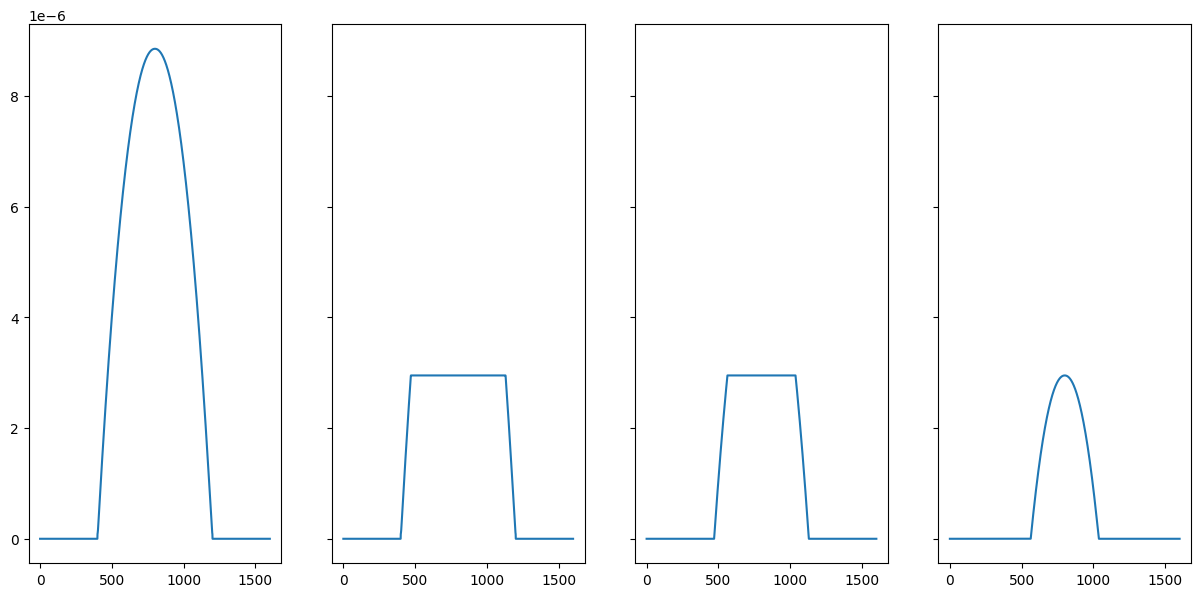

In [39]:
dir_path = r"C:\Users\Admin\Github\vulcan\vulcan\submicron_2022-10-24.05-57-53PM"
np_path = os.path.join(dir_path, "sub_um_escape.npy")
arr = np.load(np_path)

print(arr.shape)
# split pattern into 3 smaller parts 
dy, dx = np.asarray(arr.shape) // 3
split_arr = arr[:dy, :]

def decompose_arr(arr, n_decomp: int = 3) -> list[np.ndarray]:

    max_h = np.max(arr)
    frac = 1/n_decomp

    decomp = []
    min_h = 0
    for i in range(n_decomp):
        top_h = (i+1)* frac * max_h
        print(i, min_h, top_h)

        arr_deco = np.clip(arr, min_h, top_h) - min_h
        decomp.append(arr_deco)
        min_h = top_h

    return decomp

# decompose pattern into sub-patterns
decomp = decompose_arr(split_arr, n_decomp=3)

cy, cx = np.asarray(split_arr.shape) // 2

fig, ax = plt.subplots(1, len(decomp)+1, figsize=(15, 7), sharey=True)
ax[0].plot(arr[cy, :])
for i, decomp_arr in enumerate(decomp, 1):
    ax[i].plot(decomp_arr[cy, :])
# ax[1].plot(arr_s[0][cy, :])
# ax[2].plot(arr_s[1][cy, :])
# ax[3].plot(arr_s[2][cy, :])
plt.show()



### Pattern Decomposition

2022-10-31 17:46:41,672 — root — INFO — setup_milling:35 — setup ion beam milling
2022-10-31 17:46:41,673 — root — INFO — setup_milling:36 — application file:  Si, pattern mode: Serial, hfw: 0.0009


0 0 2.9502847003944526e-06
1 2.9502847003944526e-06 5.900569400788905e-06
2 5.900569400788905e-06 8.850854101183359e-06


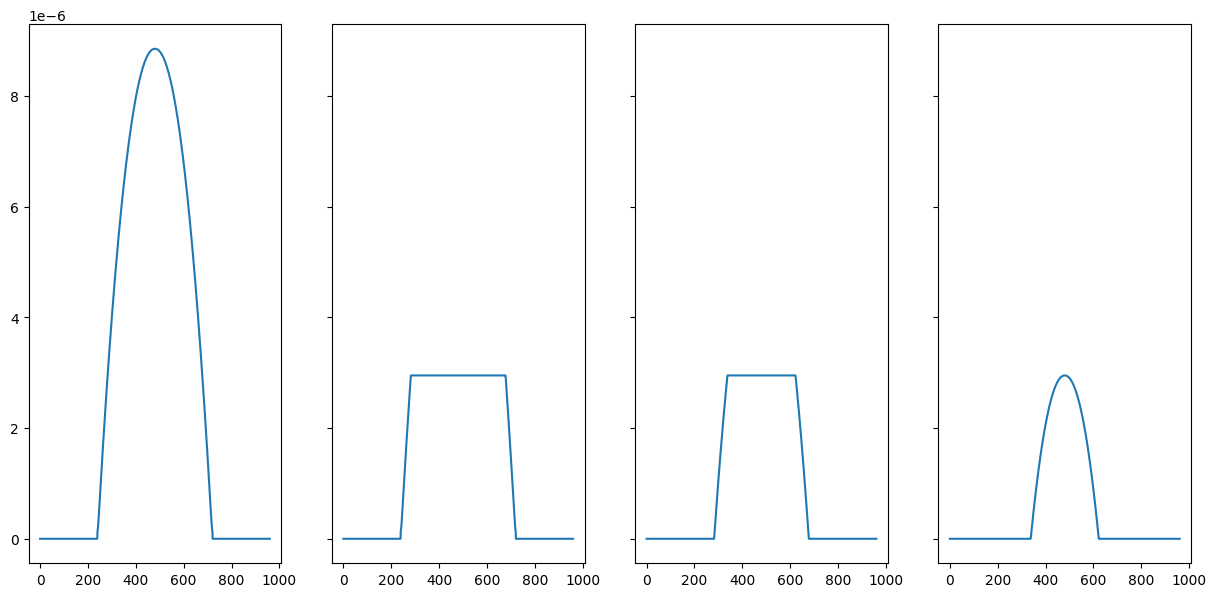

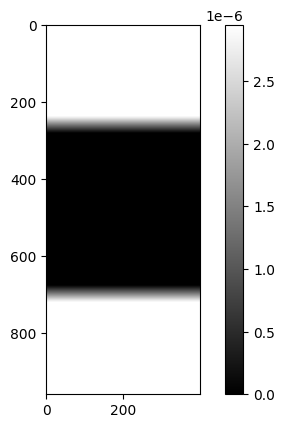

0 2.9502847003944526e-06


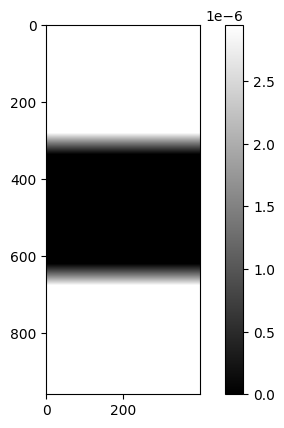

1 2.9502847003944526e-06


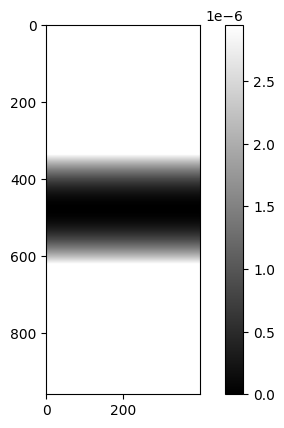

2 2.9502847003944534e-06


In [40]:
# apply each pattern as bmp

milling.setup_milling(
    microscope, 
    application_file=settings.system.application_file,
    hfw=900e-6
)

microscope.patterning.clear_patterns()

size_decomp = 3
pattern_decomp = 3

dir_path = r"C:\Users\Admin\Github\vulcan\vulcan\submicron_2022-10-24.05-57-53PM"
np_path = os.path.join(dir_path, "sub_um_escape_250nm.npy")
arr = np.load(np_path)

# split pattern into 3 smaller parts 
dy, dx = np.asarray(arr.shape) // size_decomp
split_arr = arr[:dy, :]

# decompose pattern into sub-patterns
decomp = decompose_arr(split_arr, n_decomp=pattern_decomp)

# plot decomp
fig, ax = plt.subplots(1, len(decomp)+1, figsize=(15, 7), sharey=True)
ax[0].plot(split_arr[cy, :])
for i, decomp_arr in enumerate(decomp, 1):
    ax[i].plot(decomp_arr[cy, :])
plt.show()


width = 300e-6/size_decomp
height = 240e-6
# depth = 8.85178e-6

mill_settings = MillingSettings(centre_x = 0, width=width * size_decomp, height=height, depth=0.6e-6)
rect_pattern = milling._draw_rectangle_pattern_v2(microscope, mill_settings)

for i, decomp_arr in enumerate(decomp):

    path  = os.path.join(dir_path, f"profile_{i}.bmp")
    decomp_arr = utils.transform_profile(decomp_arr, invert=True, rotate=True)
    
    plt.imshow(decomp_arr, cmap="gray")
    plt.colorbar()
    plt.show()
    utils.save_profile_to_bmp(decomp_arr, path)

    depth = np.max(decomp_arr)
    print(i, depth)

    # bmp milling
    bitmap_pattern  =  BitmapPatternDefinition.load(path)
    
    for w in [-width, 0, width]:
    
        mill_settings = MillingSettings(centre_x = w, width = width, height=height, depth=depth)
        pattern1 = milling._draw_bitmap_pattern(microscope, mill_settings, bitmap_pattern)
        pattern1.scan_direction = "DynamicAllDirections"

microscope.patterning.mode = "Parallel"


2022-10-24 18:22:30,560 — root — INFO — setup_milling:35 — setup ion beam milling
2022-10-24 18:22:30,561 — root — INFO — setup_milling:36 — application file:  Si, pattern mode: Serial, hfw: 0.0009


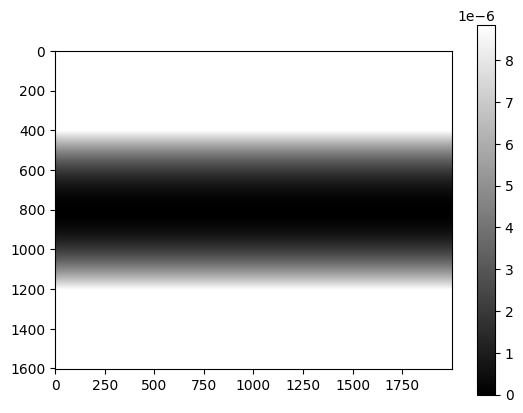

In [15]:
milling.setup_milling(
    microscope, 
    application_file=settings.system.application_file,
    hfw=900e-6
)

# dir_path = r"C:\Users\Admin\Github\vulcan\vulcan\submicron_2022-10-11.04-19-59PM"
# dir_path = r"C:\Users\Admin\Github\vulcan\vulcan\submicron_2022-10-12.12-16-08PM"

dir_path = settings.image.save_path
microscope.patterning.clear_patterns()

# profile pattern
np_path = os.path.join(dir_path, "sub_um_escape.npy")
arr = np.load(np_path)

dy, dx = np.asarray(arr.shape) // 3

split_arr = arr[:dy, :]
plt.imshow(split_arr, cmap="gray")
plt.show()

# arr = np.ones(shape=(30, 30))

path  = os.path.join(dir_path, "profile.bmp")
arr = utils.transform_profile(arr, invert=True, rotate=True)
plt.imshow(arr, cmap="gray")
plt.colorbar()
plt.show()
utils.save_profile_to_bmp(arr, path)


width = 300e-6
height = 240e-6
depth = 8.85178e-6

mill_settings = MillingSettings(centre_x = 0, width=width, height=height, depth=0.6e-6)
rect_pattern = milling._draw_rectangle_pattern_v2(microscope, mill_settings)

# bmp milling
bitmap_pattern  =  BitmapPatternDefinition.load(path)
mill_settings = MillingSettings(centre_x = 0, width =width, height=height, depth=depth)
pattern1 = milling._draw_bitmap_pattern(microscope, mill_settings, bitmap_pattern)
pattern1.scan_direction = "DynamicAllDirections"



In [80]:
milling.setup_milling(
    microscope, 
    application_file=settings.system.application_file,
    hfw=80e-6
)
# surface milling
mill_settings = MillingSettings(centre_x = -width/2 - offset, width =width, height=20e-6, depth=0.6e-6)
rect_pattern = milling._draw_rectangle_pattern_v2(microscope, mill_settings)


milling.run_milling(microscope, milling_current=60e-9)

2022-10-10 16:48:09,658 — root — INFO — run_milling:60 — running ion beam milling now... asynchronous=False


In [81]:
calibration.auto_discharge_beam(microscope, settings.image, n_iterations=n_iteration)

2022-10-10 16:48:27,051 — root — INFO — auto_discharge_beam:141 — Bring me Thanos!
2022-10-10 16:48:27,059 — root — INFO — acquire_image:186 — acquiring new ELECTRON image.
2022-10-10 16:48:27,616 — root — INFO — auto_gamma:86 — AUTO_GAMMA | Electron | 13.600 | 1.000
2022-10-10 16:48:27,623 — root — INFO — acquire_image:186 — acquiring new ELECTRON image.
2022-10-10 16:48:27,959 — root — INFO — auto_gamma:86 — AUTO_GAMMA | Electron | 10.768 | 1.000
2022-10-10 16:48:27,965 — root — INFO — acquire_image:186 — acquiring new ELECTRON image.
2022-10-10 16:48:28,345 — root — INFO — auto_gamma:86 — AUTO_GAMMA | Electron | 8.737 | 1.000
2022-10-10 16:48:28,350 — root — INFO — acquire_image:186 — acquiring new ELECTRON image.
2022-10-10 16:48:28,708 — root — INFO — auto_gamma:86 — AUTO_GAMMA | Electron | 6.560 | 1.000
2022-10-10 16:48:28,714 — root — INFO — acquire_image:186 — acquiring new ELECTRON image.
2022-10-10 16:48:29,065 — root — INFO — auto_gamma:86 — AUTO_GAMMA | Electron | 4.663 | 1

In [50]:
milling.setup_milling(
    microscope, 
    application_file=settings.system.application_file,
    hfw=80e-6
)

# surface milling
# mill_settings = MillingSettings(centre_x = -width/2 - offset, width =width, height=20e-6, depth=0.6e-6)
# rect_pattern = milling._draw_rectangle_pattern_v2(microscope, mill_settings)


# mill_settings = MillingSettings(centre_x = +width/2 + offset, width=width, height=20e-6, depth=0.6e-6)
# rect_pattern = milling._draw_rectangle_pattern_v2(microscope, mill_settings)

# # bmp milling
# bitmap_pattern  =  BitmapPatternDefinition.load(path)
# mill_settings = MillingSettings(centre_x = -width/2 - offset, width =width, height=20e-6, depth=2e-6)
# pattern1 = milling._draw_bitmap_pattern(microscope, mill_settings, bitmap_pattern)
# pattern1.scan_direction = "RightToLeft"

# pattern1.scan_direction = "DynamicAllDirections"


bitmap_pattern  =  BitmapPatternDefinition.load(path)
mill_settings = MillingSettings(centre_x = +width/2 + offset, width=width, height=20e-6, depth=2e-6)
pattern2 = milling._draw_bitmap_pattern(microscope, mill_settings, bitmap_pattern)
pattern2.scan_direction = "LeftToRight"
# pattern2.scan_direction = "DynamicAllDirections"


microscope.patterning.mode = "Serial"

# milling.run_milling(microscope, milling_current=60e-9, asynch=True)

    

2022-10-11 11:51:23,747 — root — INFO — setup_milling:35 — setup ion beam milling
2022-10-11 11:51:23,748 — root — INFO — setup_milling:36 — application file:  Si, pattern mode: Serial, hfw: 8e-05


In [79]:
milling.setup_milling(
    microscope, 
    application_file=settings.system.application_file,
    hfw=80e-6
)

# total
total_width = 40e-6

# pattern
width = 20e-6
height = 20e-6
depth = 0.6e-6
bitmap_depth = 1e-6


STEP_SIZE = width / 2
N_STEPS = 3
centre_x = - (N_STEPS - 1) * STEP_SIZE


mill_settings = MillingSettings(centre_x = 0 , width = total_width, height=height, depth=depth)
rect_pattern = milling._draw_rectangle_pattern_v2(microscope, mill_settings)

for i in range(N_STEPS):

    centre_x += STEP_SIZE

    bitmap_pattern  =  BitmapPatternDefinition.load(path)
    mill_settings = MillingSettings(centre_x = centre_x, width=width, height=height, depth=bitmap_depth)
    pattern2 = milling._draw_bitmap_pattern(microscope, mill_settings, bitmap_pattern)
    pattern2.scan_direction = "LeftToRight"


2022-10-11 12:21:46,847 — root — INFO — setup_milling:35 — setup ion beam milling
2022-10-11 12:21:46,848 — root — INFO — setup_milling:36 — application file:  Si, pattern mode: Serial, hfw: 8e-05


In [100]:
import time 

t0 = time.time()
n_iteration = 300
calibration.auto_discharge_beam(microscope, settings.image, n_iterations=n_iteration)
t1 = time.time()

elapsed = t1 - t0

2022-10-10 17:19:44,826 — root — INFO — auto_discharge_beam:141 — Bring me Thanos!
2022-10-10 17:19:44,833 — root — INFO — acquire_image:186 — acquiring new ELECTRON image.
2022-10-10 17:19:45,534 — root — INFO — auto_gamma:86 — AUTO_GAMMA | Electron | -97.856 | 0.150
2022-10-10 17:19:45,540 — root — INFO — acquire_image:186 — acquiring new ELECTRON image.
2022-10-10 17:19:45,882 — root — INFO — auto_gamma:86 — AUTO_GAMMA | Electron | -97.688 | 0.150
2022-10-10 17:19:45,888 — root — INFO — acquire_image:186 — acquiring new ELECTRON image.
2022-10-10 17:19:46,235 — root — INFO — auto_gamma:86 — AUTO_GAMMA | Electron | -97.577 | 0.150
2022-10-10 17:19:46,240 — root — INFO — acquire_image:186 — acquiring new ELECTRON image.
2022-10-10 17:19:46,579 — root — INFO — auto_gamma:86 — AUTO_GAMMA | Electron | -97.524 | 0.150
2022-10-10 17:19:46,585 — root — INFO — acquire_image:186 — acquiring new ELECTRON image.
2022-10-10 17:19:46,931 — root — INFO — auto_gamma:86 — AUTO_GAMMA | Electron | -97

In [80]:
ib_image1 = acquire.new_image(microscope, settings.image)
movement.move_stage_relative_with_corrected_movement(
    microscope,
    settings,
    dx=100e-6,
    dy=0,
    beam_type=BeamType.ION
)

ib_image2 = acquire.new_image(microscope, settings.image)

movement.move_stage_relative_with_corrected_movement(
    microscope,
    settings,
    dx=-100e-6,
    dy=0,
    beam_type=BeamType.ION
)

ib_image3 = acquire.new_image(microscope, settings.image)


fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(ib_image1.data, cmap="gray")
ax[1].imshow(ib_image2.data, cmap="gray")
ax[2].imshow(ib_image3.data, cmap="gray")
plt.show()



0

In [66]:
print("elapsed: ", elapsed)

elapsed:  107.11000752449036


In [68]:

import winsound

wait_time = 1
time.sleep(wait_time)
winsound.Beep(500, 1000)


In [101]:

beam_current = microscope.beams.ion_beam.beam_current.value
settings.image.resolution = "1536x1024"
settings.image.save_path = r"C:\Users\Admin\Github\vulcan\vulcan\vulcan_demo_2022-10-10.03-14-48PM"
settings.image.beam_type = BeamType.ELECTRON
settings.image.hfw = 60e-6
settings.image.save = True
# settings.image.label = f"stitch_{beam_current:.2e}_offset_{offset*1e6}_dis_{elapsed:.2f}_wait_{wait_time}_p1"
settings.image.label = "stitch_baseline-dynamic-all-directions2"
image = acquire.new_image(microscope, settings.image)

2022-10-10 17:24:05,464 — root — INFO — acquire_image:186 — acquiring new ELECTRON image.
2022-10-10 17:24:06,145 — root — INFO — auto_gamma:86 — AUTO_GAMMA | Electron | -80.015 | 0.200


In [86]:
milling.setup_milling(
    microscope, 
    application_file=settings.system.application_file,
    hfw=80e-6
)

mill_settings = MillingSettings(centre_x = +width/2 + offset, width=width, height=20e-6, depth=0.6e-6)
rect_pattern = milling._draw_rectangle_pattern_v2(microscope, mill_settings)

milling.run_milling(microscope, milling_current=60e-9)


2022-10-10 16:54:10,508 — root — INFO — setup_milling:35 — setup ion beam milling
2022-10-10 16:54:10,508 — root — INFO — setup_milling:36 — application file:  Si, pattern mode: Serial, hfw: 8e-05
2022-10-10 16:54:10,863 — root — INFO — run_milling:60 — running ion beam milling now... asynchronous=False


In [87]:
calibration.auto_discharge_beam(microscope, settings.image, n_iterations=n_iteration)

2022-10-10 16:54:51,811 — root — INFO — auto_discharge_beam:141 — Bring me Thanos!
2022-10-10 16:54:51,817 — root — INFO — acquire_image:186 — acquiring new ELECTRON image.
2022-10-10 16:54:52,393 — root — INFO — auto_gamma:86 — AUTO_GAMMA | Electron | -12.882 | 1.000
2022-10-10 16:54:52,398 — root — INFO — acquire_image:186 — acquiring new ELECTRON image.
2022-10-10 16:54:52,745 — root — INFO — auto_gamma:86 — AUTO_GAMMA | Electron | -12.455 | 1.000
2022-10-10 16:54:52,750 — root — INFO — acquire_image:186 — acquiring new ELECTRON image.
2022-10-10 16:54:53,091 — root — INFO — auto_gamma:86 — AUTO_GAMMA | Electron | -12.471 | 1.000
2022-10-10 16:54:53,097 — root — INFO — acquire_image:186 — acquiring new ELECTRON image.
2022-10-10 16:54:53,429 — root — INFO — auto_gamma:86 — AUTO_GAMMA | Electron | -12.092 | 1.000
2022-10-10 16:54:53,435 — root — INFO — acquire_image:186 — acquiring new ELECTRON image.
2022-10-10 16:54:53,775 — root — INFO — auto_gamma:86 — AUTO_GAMMA | Electron | -11

In [88]:
milling.setup_milling(
    microscope, 
    application_file=settings.system.application_file,
    hfw=80e-6
)

bitmap_pattern  =  BitmapPatternDefinition.load(path)
mill_settings = MillingSettings(centre_x = +width/2 + offset, width=width, height=20e-6, depth=2e-6)
pattern2 = milling._draw_bitmap_pattern(microscope, mill_settings, bitmap_pattern)
pattern2.scan_direction = "LeftToRight"

microscope.patterning.mode = "Serial"

milling.run_milling(microscope, milling_current=60e-9)


2022-10-10 16:56:43,672 — root — INFO — setup_milling:35 — setup ion beam milling
2022-10-10 16:56:43,673 — root — INFO — setup_milling:36 — application file:  Si, pattern mode: Serial, hfw: 8e-05
2022-10-10 16:56:44,036 — root — INFO — run_milling:60 — running ion beam milling now... asynchronous=False


In [89]:
calibration.auto_discharge_beam(microscope, settings.image, n_iterations=n_iteration)

2022-10-10 16:57:24,080 — root — INFO — auto_discharge_beam:141 — Bring me Thanos!
2022-10-10 16:57:24,086 — root — INFO — acquire_image:186 — acquiring new ELECTRON image.
2022-10-10 16:57:24,640 — root — INFO — auto_gamma:86 — AUTO_GAMMA | Electron | 26.266 | 1.000
2022-10-10 16:57:24,646 — root — INFO — acquire_image:186 — acquiring new ELECTRON image.
2022-10-10 16:57:24,992 — root — INFO — auto_gamma:86 — AUTO_GAMMA | Electron | 23.825 | 1.000
2022-10-10 16:57:24,997 — root — INFO — acquire_image:186 — acquiring new ELECTRON image.
2022-10-10 16:57:25,361 — root — INFO — auto_gamma:86 — AUTO_GAMMA | Electron | 21.163 | 1.000
2022-10-10 16:57:25,367 — root — INFO — acquire_image:186 — acquiring new ELECTRON image.
2022-10-10 16:57:25,709 — root — INFO — auto_gamma:86 — AUTO_GAMMA | Electron | 18.866 | 1.000
2022-10-10 16:57:25,715 — root — INFO — acquire_image:186 — acquiring new ELECTRON image.
2022-10-10 16:57:26,085 — root — INFO — auto_gamma:86 — AUTO_GAMMA | Electron | 16.447 

In [90]:
from fibsem import acquire
from fibsem.structures import BeamType

beam_current = microscope.beams.ion_beam.beam_current.value
settings.image.resolution = "1536x1024"
settings.image.save_path = r"C:\Users\Admin\Github\vulcan\vulcan\vulcan_demo_2022-10-10.03-14-48PM"
settings.image.beam_type = BeamType.ELECTRON
settings.image.hfw = 60e-6
settings.image.save = True
settings.image.label = f"stitch_{beam_current:.2e}_offset_{offset*1e6}_dis_{elapsed:.2f}_wait_{wait_time}_p2_topdown"
image = acquire.new_image(microscope, settings.image)

2022-10-10 16:59:13,551 — root — INFO — acquire_image:186 — acquiring new ELECTRON image.
2022-10-10 16:59:14,241 — root — INFO — auto_gamma:86 — AUTO_GAMMA | Electron | 57.480 | 1.575


### Calibration

Resolution vs Depth

How does changing the resolution of the bitmap pattern affect the depth?

In [ ]:
milling.setup_milling(
    microscope, 
    application_file=settings.system.application_file,
    hfw=400e-6
)

In [ ]:
# paths = range(4)
# paths = [r"C:\Users\Admin\Github\vulcan\vulcan\profiles\calibration\1e-06_profile.bmp"]
# r"C:\Users\Admin\Github\vulcan\vulcan\profiles\calibration\1e-06_rect.bmp"]



microscope.patterning.clear_patterns()

width = 800e-6
height = 400e-6
depth = 5e-6
offset = 0e-6
center_x = 0
center_y = -(len(paths) - 1) / 2 * (height + offset) 

mill_settings = MillingSettings(centre_x=center_x, centre_y=0, 
    width=width, 
    height=height, 
    depth=600e-9)

pattern = milling._draw_rectangle_pattern_v2(microscope, mill_settings)


for path in paths:

    # profile pattern
    bitmap_pattern  =  BitmapPatternDefinition.load(path)
    mill_settings = MillingSettings(centre_x=center_x, centre_y=center_y, width=width, height=height, depth=depth)
    pattern = milling._draw_bitmap_pattern(microscope, mill_settings, bitmap_pattern)

    print(mill_settings)

    center_y +=  height + offset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# np_path = r"C:\Users\Admin\Github\vulcan\vulcan\profiles\calibration/1e-06_profile.npy"
np_path = r"C:\Users\Admin\Github\vulcan\vulcan\profiles\lens_lowres_half.npy"
arr = np.load(np_path)

print(arr.shape)
plt.plot(arr[0])
plt.show()

# dirname = os.path.dirname(np_path)
# fname = os.path.basename(np_path).split(".")[0]
# fname = np_path.replace("npy", "bmp")
# print(fname)

arr = utils.transform_profile(arr, invert=True, rotate=False)
utils.save_profile_to_bmp(arr, fname)

In [ ]:
print("30x: ", arr.shape[1] * 30)
print("100x (10nm): ", arr.shape[1] * 100)
print("1000x (1nm): ", arr.shape[1] * 1000)

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import tifffile as tf
import numpy as np

path = r"C:\Users\Admin\Github\vulcan\vulcan\profiles\helloworld.tif"

utils.convert_tif_to_bmp(path, "pattern.bmp")

plt.imshow(arr)
plt.show()

In [ ]:
x = "Hello world"
print(str(x))


In [ ]:

arr = np.ones(shape=(200, 40))
path = r"C:\Users\Admin\Github\vulcan\vulcan\profiles\calibration"
fname = os.path.join(path, f"{arr.shape[0]}.{arr.shape[1]}.bmp")
utils.save_profile_to_bmp(arr, fname)

print("elements: ", arr.size)
# microscope.patterning.clear_patterns()

width = 40e-6
height = 20e-6
depth_step = 3e-6
offset = 30e-6
center_x = 0
center_y = -(2 - 1) / 2 * (height + offset) 

# center_y = 0
# mill_settings = MillingSettings(centre_x=center_x, centre_y=0, 
#     width=width, 
#     height=height, 
#     depth=600e-9)

# pattern = milling._draw_rectangle_pattern_v2(microscope, mill_settings)

depth = 2e-6

for i in range(2):

    # profile pattern
    bitmap_pattern  =  BitmapPatternDefinition.load(fname)
    mill_settings = MillingSettings(centre_x=center_x, centre_y=center_y, width=width, height=height, depth=depth)
    pattern = milling._draw_bitmap_pattern(microscope, mill_settings, bitmap_pattern)
    
    center_y +=  height + offset
    depth += depth_step

    print("depth: ", pattern.depth)
    print("passes: ", pattern.pass_count)
    print("vol per dose: ", pattern.volume_per_dose)
    print("dose: ", pattern.dose)


In [ ]:
pattern.dose *= 2.5

In [ ]:
pattern.depth


In [ ]:
rect_pattern.dose

In [ ]:
pattern.depth

In [ ]:
pattern.dwell_time

In [ ]:
import numpy as np

arr = np.ones(shape=(200, 200))

fname = r"C:\Users\Admin\Github\vulcan\vulcan\profiles\calibration/1um.bmp"
arr = utils.transform_profile(arr, invert=False, rotate=False)
utils.save_profile_to_bmp(arr, fname)

(200, 881)


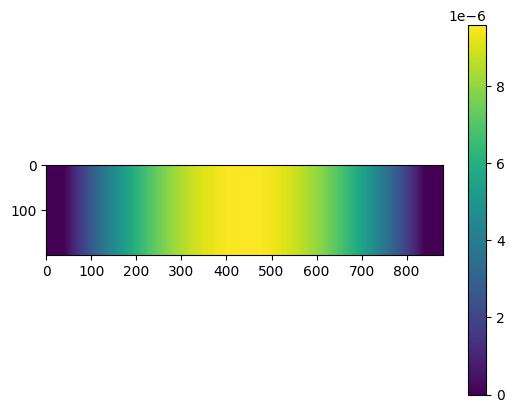

In [44]:
np_path = r"C:\Users\Admin\Github\vulcan\vulcan\profiles\lens_lowres_half.npy"
arr = np.load(np_path)

print(arr.shape)
plt.imshow(arr)
plt.colorbar()
plt.show()

(881, 200)


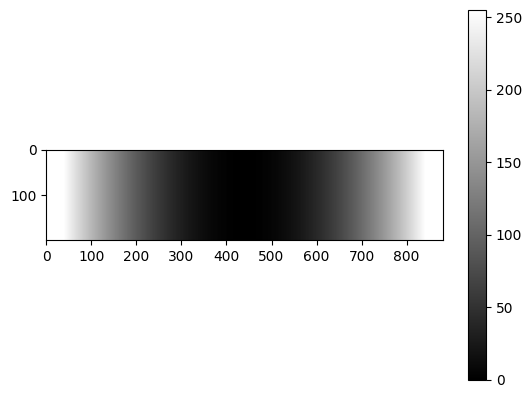

In [47]:
img_path = r"C:\Users\Admin\Github\vulcan\vulcan\profiles\lens_lowres_half.bmp"

from PIL import Image

img = Image.open(img_path)

print(img.size)
plt.imshow(img, cmap="gray")
plt.colorbar()
plt.show()